# Erosion Detection Training

This notebook downloads a sample dataset, adds synthetic sensor data, computes correlations between image features and sensors, and trains a simple model.


In [1]:
# Install dependencies if running on a fresh environment
!pip install -q -r ../requirements.txt



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Download CIFAR10 as a placeholder dataset
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)


In [4]:
# Create synthetic sensor data correlated with class label
np.random.seed(0)
labels = np.array(train_ds.targets)
sensors = pd.DataFrame({
    'rainfall': labels * 10 + np.random.randn(len(labels)) * 2,
    'slope': labels * 5 + np.random.randn(len(labels)) * 1.5,
    'humidity': labels * 8 + np.random.randn(len(labels)) * 1.0,
})


In [5]:
# Correlate sensors with labels
correlation = sensors.corrwith(pd.Series(labels, name='label'))
print(correlation)


rainfall    0.997600
slope       0.994602
humidity    0.999060
dtype: float64


In [6]:
# Create a dataset that includes images and sensors
class SensorImageDataset(Dataset):
    def __init__(self, image_ds, sensor_df):
        self.image_ds = image_ds
        self.sensor_df = sensor_df.reset_index(drop=True)
    def __len__(self):
        return len(self.image_ds)
    def __getitem__(self, idx):
        image, label = self.image_ds[idx]
        sensors = torch.tensor(self.sensor_df.iloc[idx].values, dtype=torch.float32)
        return image, sensors, label

full_ds = SensorImageDataset(train_ds, sensors)
loader = DataLoader(full_ds, batch_size=64, shuffle=True)


In [7]:
# Simple model combining CNN features with sensor data
import torch.nn as nn
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc_image = nn.Linear(32, 16)
        self.fc_sensor = nn.Linear(3, 16)
        self.classifier = nn.Linear(32, 10)
    def forward(self, x_img, x_sensor):
        x = self.cnn(x_img)
        x = x.view(x.size(0), -1)
        x_img_feat = self.fc_image(x)
        x_sensor_feat = self.fc_sensor(x_sensor)
        x = torch.cat([x_img_feat, x_sensor_feat], dim=1)
        return self.classifier(x)
model = SimpleModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [8]:
# Train for a few epochs
for epoch in range(2):
    for images, sensor_values, labels in loader:
        optimizer.zero_grad()
        outputs = model(images, sensor_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} complete, loss: {loss.item():.4f}')


Epoch 1 complete, loss: 0.5599
Epoch 2 complete, loss: 0.5386


Training complete.

In [9]:
# Load test dataset for evaluation
test_ds = datasets.CIFAR10(root='data', train=False, download=False, transform=transform)

# Create synthetic sensor data for test set
test_labels = np.array(test_ds.targets)
test_sensors = pd.DataFrame({
    'rainfall': test_labels * 10 + np.random.randn(len(test_labels)) * 2,
    'slope': test_labels * 5 + np.random.randn(len(test_labels)) * 1.5,
    'humidity': test_labels * 8 + np.random.randn(len(test_labels)) * 1.0,
})

test_full_ds = SensorImageDataset(test_ds, test_sensors)
test_loader = DataLoader(test_full_ds, batch_size=64, shuffle=False)


In [10]:
# Import additional libraries for testing and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from torch.utils.data import random_split


In [11]:
def evaluate_model(model, test_loader, device='cpu'):
    """
    Comprehensive model evaluation function
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    total_loss = 0
    
    with torch.no_grad():
        for images, sensor_values, labels in test_loader:
            images, sensor_values, labels = images.to(device), sensor_values.to(device), labels.to(device)
            
            outputs = model(images, sensor_values)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    avg_loss = total_loss / len(test_loader)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'avg_loss': avg_loss,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }


In [12]:
# Run evaluation on test set
print("Evaluating model on test set...")
test_results = evaluate_model(model, test_loader)

# Print results
print(f"\n=== Model Performance Metrics ===")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall: {test_results['recall']:.4f}")
print(f"Test F1-Score: {test_results['f1']:.4f}")
print(f"Test Loss: {test_results['avg_loss']:.4f}")


Evaluating model on test set...

=== Model Performance Metrics ===
Test Accuracy: 0.9430
Test Precision: 0.9501
Test Recall: 0.9430
Test F1-Score: 0.9416
Test Loss: 0.2817


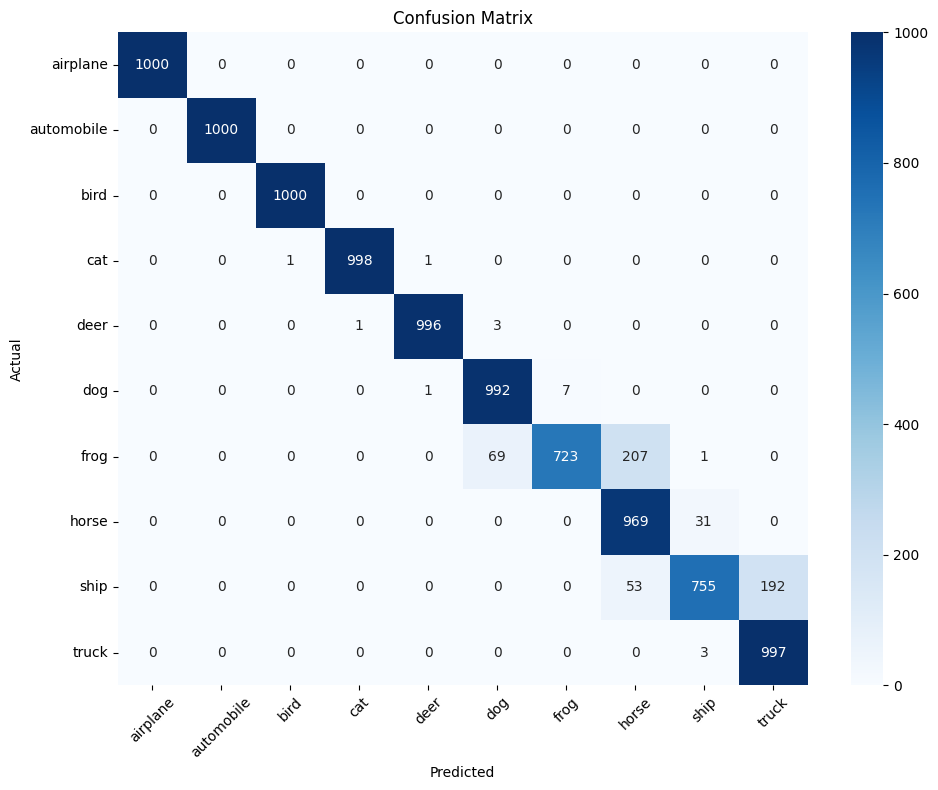

In [13]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_results['labels'], test_results['predictions'])

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [14]:
# Analyze sensor data correlations with predictions
print("=== Sensor Data Analysis ===")

# Test predictions vs actual labels correlation with sensors
test_pred_df = pd.DataFrame({
    'predictions': test_results['predictions'],
    'actual_labels': test_results['labels'],
    'rainfall': test_sensors['rainfall'].values,
    'slope': test_sensors['slope'].values,
    'humidity': test_sensors['humidity'].values
})

# Correlations
pred_corr = test_pred_df[['rainfall', 'slope', 'humidity']].corrwith(
    pd.Series(test_pred_df['predictions'], name='predictions'))
actual_corr = test_pred_df[['rainfall', 'slope', 'humidity']].corrwith(
    pd.Series(test_pred_df['actual_labels'], name='actual'))

print(f"\nCorrelations with Predictions:")
for sensor, corr in pred_corr.items():
    print(f"  {sensor}: {corr:.4f}")

print(f"\nCorrelations with Actual Labels:")
for sensor, corr in actual_corr.items():
    print(f"  {sensor}: {corr:.4f}")

# Calculate prediction accuracy by sensor value ranges
print(f"\n=== Performance by Sensor Ranges ===")
for sensor in ['rainfall', 'slope', 'humidity']:
    values = test_pred_df[sensor]
    quartiles = np.percentile(values, [25, 50, 75])
    
    low_mask = values <= quartiles[0]
    mid_mask = (values > quartiles[0]) & (values <= quartiles[2])
    high_mask = values > quartiles[2]
    
    low_acc = np.mean(test_pred_df.loc[low_mask, 'predictions'] == test_pred_df.loc[low_mask, 'actual_labels'])
    mid_acc = np.mean(test_pred_df.loc[mid_mask, 'predictions'] == test_pred_df.loc[mid_mask, 'actual_labels'])
    high_acc = np.mean(test_pred_df.loc[high_mask, 'predictions'] == test_pred_df.loc[high_mask, 'actual_labels'])
    
    print(f"{sensor} - Low: {low_acc:.3f}, Mid: {mid_acc:.3f}, High: {high_acc:.3f}")


=== Sensor Data Analysis ===

Correlations with Predictions:
  rainfall: 0.9951
  slope: 0.9920
  humidity: 0.9961

Correlations with Actual Labels:
  rainfall: 0.9976
  slope: 0.9947
  humidity: 0.9991

=== Performance by Sensor Ranges ===
rainfall - Low: 1.000, Mid: 0.939, High: 0.894
slope - Low: 1.000, Mid: 0.940, High: 0.893
humidity - Low: 1.000, Mid: 0.939, High: 0.894


In [15]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_results['accuracy'],
    'test_f1': test_results['f1'],
}, 'erosion_model_baseline.pth')

print("Model saved as 'erosion_model_baseline.pth'")


Model saved as 'erosion_model_baseline.pth'
